In [380]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

from pyproj import Transformer
import geopandas as gpd
from shapely import Point
import contextily as ctx

import os
from urllib.request import urlretrieve
from zipfile import ZipFile


# Helper Functions

These functions train a model on your data and use cross validation to determine the average negative mean squared error. You do not have to edit these! However, it might make sense to add new helper functions here.

In [381]:
def scoreLinear(X, y):
    """Trains a linear regression model and evaluates it with 3-fold cross validation.
  
    Parameters: 
    X (array): Training data of shape (n_samples, n_features)
    y (array): Target values of shape (n_samples,)
  
    Returns: 
    Float: average score of the model after cross validation
    """
    regr = linear_model.LinearRegression()
    scores = cross_val_score(regr, X, y, cv=3, scoring='neg_mean_squared_error')
    return scores.mean()

In [382]:
def scoreBoosting(X, y):
    """Trains a gradient boosting model and evaluates it with 3-fold cross validation.
  
    Parameters: 
    X (array): Training data of shape (n_samples, n_features)
    y (array): Target values of shape (n_samples,)
  
    Returns: 
    Float: average score of the model after cross validation
    """
    clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=0, loss='squared_error')
    # clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=0, loss='ls') # older versions

    scores = cross_val_score(clf, X, np.ravel(y), cv=3, scoring='neg_mean_squared_error')
    return scores.mean()

In [383]:
def dataframeToXy(df, predict_column, feature_columns):
    """Convert the dataframe to a format usable for the ML algorithms"""
    X = df[feature_columns].values.reshape(-1, df[feature_columns].shape[1]) # all features
    y = df[[predict_column]].values.reshape(-1, 1) # values to predict
    return X, y

In [384]:
def runScoring(df, predict_column, feature_columns):
    """This runs both algorithms to determine the scores for all given features in the dataset.
    
    Parameters: 
    df (dataframe): dataframe with Score and features
    predict_column: name of the value to predict, e.g. 'Score'
    feature_columns: list of all column names that are to be used as features
  
    Returns: 
    linear: negative mean squared error of linear regression
    boost: negative mean squared error of boosting algorithm
    """
    X, y = dataframeToXy(df, predict_column, feature_columns)
    boost = scoreBoosting(X, y)
    linear = scoreLinear(X, y)
    return linear, boost

In [385]:
def runScoringSimple(df, predict_column):
    """Alternative to function above, this takes all the columns in the 
    dataframe as features except the single column which is used for the score.
    """
    all_feature_columns = list(df.columns)
    all_feature_columns.remove(predict_column)
    return runScoring(df, predict_column, all_feature_columns)

In [386]:
def createBaselineRandom(df, predict_column):
    """creates random features and returns the average score after 20 rounds"""
    np.random.seed(0)
    baseline = df[['Score']].copy()
    averageLinearScore = 0
    averageBoostingScore = 0
    rounds = 20
    for i in range(rounds):
        baseline['feature1'] = np.random.randint(0, 100, df.shape[0])
        baseline['feature2'] = np.random.randint(0, 100, df.shape[0])
        baseline['feature3'] = np.random.randint(0, 100, df.shape[0])
        lin, boost = runScoring(baseline, predict_column, ['feature1', 'feature2', 'feature3'])
        averageLinearScore += lin / rounds
        averageBoostingScore += boost / rounds
    print(f'linear   : {averageLinearScore}')
    print(f'boosting : {averageBoostingScore}')

In [387]:
def from_lv03_to_en(x:float, y:float):
    transformer = Transformer.from_crs('epsg:21781', 'epsg:2056')
    return transformer.transform(x, y)

In [388]:
def from_en_to_lv03(e:float, n:float):
    transformer = Transformer.from_crs('epsg:2056', 'epsg:21781')
    return transformer.transform(e, n)

# Load Data


The previous task entailed data scraping from diverse sources and subsequent compilation into a ranking format. This current assignment centers on the development of a machine learning model. The data acquired from the preceding assignment is accessible within the "data" directory. The subsequent cell presents the outcomes alongside three distinct rankings. The primary objective of this model is to forecast the workers' scores, with other metrics excluded as features.

In [389]:
df_ranking = pd.read_csv('./data/scraped/Ranking.csv')
df_ranking

,Gemeinde,Alters ranking,Arbeiter ranking,Lärm ranking,Score alter,Score arbeit,Score Lärm
0,Alpnach,12.551816,3165,56,28.417598,36.358415,44
1,Engelberg,23.415451,2600,40,53.013116,29.867892,60
2,Giswil,24.548934,1358,0,55.579348,15.600230,100
3,Kerns,44.169165,2462,18,100.000000,28.282596,82
4,Lungern,6.415094,1169,24,14.523920,13.429064,76
5,Sachseln,0.000000,3338,29,0.000000,38.345778,71
6,Sarnen,0.000000,8705,28,0.000000,100.000000,72


In [390]:
df_model = df_ranking[["Gemeinde", "Score arbeit", "Lärm ranking", "Alters ranking"]]
df_model.columns = ["Gemeinde", "Score", "noise_feature", "age_feature"]
communities = df_model["Gemeinde"]
df_model.set_index('Gemeinde', inplace=True)
df_model

,Score,noise_feature,age_feature
Gemeinde,,,
Alpnach,36.358415,56,12.551816
Engelberg,29.867892,40,23.415451
Giswil,15.600230,0,24.548934
Kerns,28.282596,18,44.169165
Lungern,13.429064,24,6.415094
Sachseln,38.345778,29,0.000000
Sarnen,100.000000,28,0.000000


# Get a first baseline with random values

In [391]:
# This code creates a baseline for your model, using random features
createBaselineRandom(df_model, 'Score')

linear   : -25671.94714112528
boosting : -2089.899036609705


# Get a second baseline by using all features you have

In [392]:
# this assumes we have a dataframe with a column named Score and all other columns are features.
# You might have to change this code if your dataframe looks different.

score, boost = runScoringSimple(df_model, 'Score')
print(f'linear   : {score}')
print(f'boosting : {boost}')

linear   : -25918.791175775146
boosting : -1531.7341093771292


## Additional Features from Gemeindeporträts

### Analyzing the Gemeindeportrait Dataset

The Gemeindeportrait dataset provides a valuable opportunity to enhance our predictive models by identifying and analyzing potential influential features. This process focuses on integrating our intuition and data analysis to improve model performance.

#### Process Outline:

1. **Identifying Features**:
   - Begin by hypothesizing which features could positively influence the model, based on domain knowledge and preliminary data exploration.

2. **Data Analysis**:
   - Examine the hypothesized features in relation to the dataset, particularly how they correlate with the target prediction column.

3. **Integration and Testing**:
   - Append the most promising features to the main model dataframe.
   - Evaluate the updated model's performance to assess the impact of these new features.

This structured approach aims to not only enhance the model's accuracy but also deepen our understanding of the data's underlying dynamics, leading to more robust predictions.


In [393]:
df_portrtait = pd.read_excel('./data/GemeindePortraits2021.xlsx', skiprows=5)
df_portrtait.drop("Gemeindecode", axis=1, inplace=True)
df_portrtait.drop([0, 1], inplace=True)                               #year and new line not needed
df_portrtait.drop(df_portrtait.index[2173:], inplace=True)            #the last few rows dont have data
df_portrtait

,Gemeindename,Einwohner,Veränderung in %,Bevölkerungs-dichte pro km²,Ausländer in %,0-19 Jahre,20-64 Jahre,65 Jahre und mehr,Rohe Heiratssziffer,Rohe Scheidungsziffer,...,im 1. Sektor,im 2. Sektor,im 3. Sektor,Arbeitsstätten total,im 1. Sektor.1,im 2. Sektor.1,im 3. Sektor.1,Leerwohnungs-ziffer,Neu gebaute Wohnungen pro 1000 Einwohner,Sozialhilfequote
2,Schweiz,8606033.0,9.4,215.200000,25.300000,20.000000,61.400000,18.700000,4.500000,2.000000,...,161497,1091626,3996835,687022,53457,95687,537878,1.720000,6.300000,3.2
3,Aeugst am Albis,1981.0,8.607456,250.442478,14.184755,19.787986,62.190813,18.021201,7.065355,2.018673,...,39,25,378,141,15,16,110,5.291577,13.910355,1.01
4,Affoltern am Albis,12303.0,10.927779,1161.756374,28.700317,20.165813,61.667886,18.166301,5.543780,1.793576,...,47,1307,5566,995,23,134,838,1.005548,3.787255,3.02
5,Bonstetten,5572.0,8.005427,749.932705,16.564968,23.636037,59.834889,16.529074,4.316547,1.798561,...,34,111,869,281,14,26,241,1.171717,0.181422,1.51
6,Hausen am Albis,3751.0,11.636905,275.808824,16.022394,22.180752,59.824047,17.995201,3.220612,1.610306,...,93,136,792,271,36,38,197,0.630011,3.002183,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2170,Vendlincourt,559.0,1.821494,61.092896,7.155635,18.425760,56.887299,24.686941,7.279345,0.000000,...,31,182,28,35,11,10,14,2.749141,0.000000,1.67
2171,Basse-Allaine,1238.0,-5.279265,53.732639,9.127625,21.728595,52.988691,25.282714,4.051864,0.810373,...,149,186,139,96,34,19,43,2.155172,0.825083,2.11
2172,Clos du Doubs,1263.0,0.158604,20.453441,7.284244,18.289786,56.611243,25.098971,3.138486,1.569243,...,205,91,349,163,69,28,66,2.422145,1.534919,2.1
2173,Haute-Ajoie,1085.0,-6.060606,26.508673,8.387097,17.788018,55.483871,26.728111,5.504587,1.834862,...,136,472,174,115,47,14,54,3.869048,4.528986,2.37


In [394]:
#filter the data set to get the target communities
pattern = '|'.join(communities)
df_target = df_portrtait[df_portrtait["Gemeindename"].str.contains(pattern, regex=True)].reset_index()
df_target = df_target[['Gemeindename', 'Neu gebaute Wohnungen pro 1000 Einwohner'
           , 'Einwohner', 'Anzahl Privathaushalte', 'Sozialhilfequote']]

df_target.columns = ['Gemeinde', 'Neue Wohnungen', 'Einwohner', 'Haushalte', 'Sozialhilfe']
df_target

,Gemeinde,Neue Wohnungen,Einwohner,Haushalte,Sozialhilfe
0,Alpnach,2.988048,6053.0,2541.0,1.06
1,Engelberg,0.481348,4186.0,1984.0,1.82
2,Giswil,1.643385,3657.0,1519.0,0.85
3,Kerns,7.783956,6295.0,2554.0,0.85
4,Lungern,3.770028,2111.0,926.0,1.27
5,Sachseln,7.855460,5170.0,2135.0,0.8
6,Sarnen,8.010942,10458.0,4533.0,1.13


In [395]:
#appending the data and visualize them
df_model = df_model.merge(df_target, on='Gemeinde')
df_model

,Gemeinde,Score,noise_feature,age_feature,Neue Wohnungen,Einwohner,Haushalte,Sozialhilfe
0,Alpnach,36.358415,56,12.551816,2.988048,6053.0,2541.0,1.06
1,Engelberg,29.867892,40,23.415451,0.481348,4186.0,1984.0,1.82
2,Giswil,15.600230,0,24.548934,1.643385,3657.0,1519.0,0.85
3,Kerns,28.282596,18,44.169165,7.783956,6295.0,2554.0,0.85
4,Lungern,13.429064,24,6.415094,3.770028,2111.0,926.0,1.27
5,Sachseln,38.345778,29,0.000000,7.855460,5170.0,2135.0,0.8
6,Sarnen,100.000000,28,0.000000,8.010942,10458.0,4533.0,1.13


In [396]:
#testing the model with the new features
df_model.set_index("Gemeinde", inplace=True)
score, boost = runScoringSimple(df_model, 'Score')
print(f'linear: {score}')
print(f'boost:  {boost}')

linear: -318.8280286407889
boost:  -864.9063800065255


## Geographic Feature extension

### Geographic Feature: Public Accessibility
The concept underlying the geographic feature of public accessibility is that communities with a higher number of workers need more extensive development of streets and public transportation infrastructure to facilitate their commute to work. 

The map utilized is sourced from the geoadmin API and can be downloaded via the __DOWNLOAD_URL__. Subsequent cells will manage the download process to streamline result reproduction. For further documentation regarding the map, please refer to [this link](https://data.geo.admin.ch/browser/index.html#/collections/ch.are.gueteklassen_oev?.language=en).

In [397]:
def download_map():
    if(not os.path.exists('./data/geodata')):
        __DOWNLOAD_URL__ = 'https://data.geo.admin.ch/ch.are.gueteklassen_oev/gueteklassen_oev_2023/gueteklassen_oev_2023_2056.gpkg.zip'
        urlretrieve(__DOWNLOAD_URL__, './data/geodata.zip')
        with ZipFile('./data/geodata.zip', 'r') as file:
            file.extractall('./data/geodata')
            file.close()
        os.remove('./data/geodata.zip')

In [398]:
#Coordinates of the communities from last assignment
df_coord = pd.read_csv('./data/scraped/Noise_Extract.csv')
df_coord = df_coord.drop(["noise_night"], axis=1)
df_coord

,community,X_lv03,Y_lv03
0,Alpnach,201314.000000,664633.1250
1,Engelberg,190537.078125,671109.9375
2,Giswil,187475.812500,652028.5000
3,Kerns,195402.140625,665796.9375
4,Lungern,184744.062500,655534.3125
5,Sachseln,191896.921875,662542.4375
6,Sarnen,191597.078125,659204.2500


In [399]:
download_map()
gdf_access = gpd.read_file("./data/geodata/OeV_Gueteklassen_ARE.gpkg")
gdf_access.head(5)


,KLASSE,KLASSE_DE,KLASSE_FR,geometry
0,D,D - geringe Erschliessung,D - faible desserte,"POLYGON ((2488081.647 1112059.673, 2488078.065..."
1,D,D - geringe Erschliessung,D - faible desserte,"POLYGON ((2488281.815 1116818.633, 2488232.076..."
2,D,D - geringe Erschliessung,D - faible desserte,"POLYGON ((2488549.508 1115494.267, 2488558.170..."
3,D,D - geringe Erschliessung,D - faible desserte,"POLYGON ((2487515.311 1117405.777, 2487403.342..."
4,D,D - geringe Erschliessung,D - faible desserte,"POLYGON ((2488287.673 1118120.999, 2488264.837..."


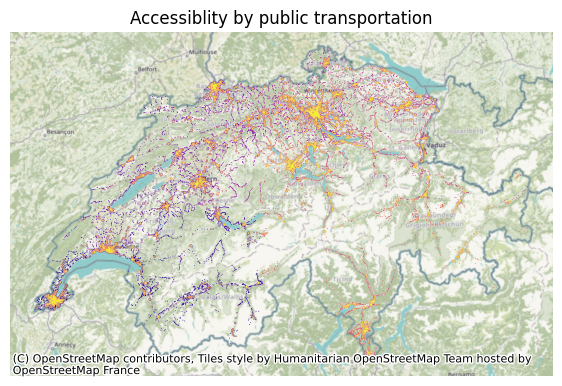

In [400]:
#plotting the map
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.set_title('Accessiblity by public transportation')
ax.set_axis_off()
gdf_access.plot(ax=ax, cmap='plasma')
ctx.add_basemap(ax=ax, crs=gdf_access.crs.to_string())

In [401]:
#for reference if the filtered data still has points which are not in the canton
#converting the lv03 coord to en coord
en_coord = from_lv03_to_en(df_coord["Y_lv03"], df_coord['X_lv03'])

#data for plotting and grouping in communities
gdf_reference = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in zip(en_coord[0], en_coord[1])], crs='EPSG:2056')
gdf_reference['zone_id'] = df_coord["community"]
buffer = gdf_reference.buffer(1500)       # 1,5km raduis
gdf_reference

,geometry,zone_id
0,POINT (2664633.125 1201314.000),Alpnach
1,POINT (2671109.938 1190537.078),Engelberg
2,POINT (2652028.500 1187475.813),Giswil
3,POINT (2665796.938 1195402.141),Kerns
4,POINT (2655534.312 1184744.063),Lungern
5,POINT (2662542.438 1191896.922),Sachseln
6,POINT (2659204.250 1191597.078),Sarnen


In [402]:
#extract the class for each zone
gdf_class = gpd.sjoin(gdf_reference, gdf_access, how='left', predicate='within')
gdf_class


,geometry,zone_id,index_right,KLASSE,KLASSE_DE,KLASSE_FR
0,POINT (2664633.125 1201314.000),Alpnach,NaN,NaN,NaN,NaN
1,POINT (2671109.938 1190537.078),Engelberg,NaN,NaN,NaN,NaN
2,POINT (2652028.500 1187475.813),Giswil,NaN,NaN,NaN,NaN
3,POINT (2665796.938 1195402.141),Kerns,NaN,NaN,NaN,NaN
4,POINT (2655534.312 1184744.063),Lungern,NaN,NaN,NaN,NaN
5,POINT (2662542.438 1191896.922),Sachseln,NaN,NaN,NaN,NaN
6,POINT (2659204.250 1191597.078),Sarnen,NaN,NaN,NaN,NaN


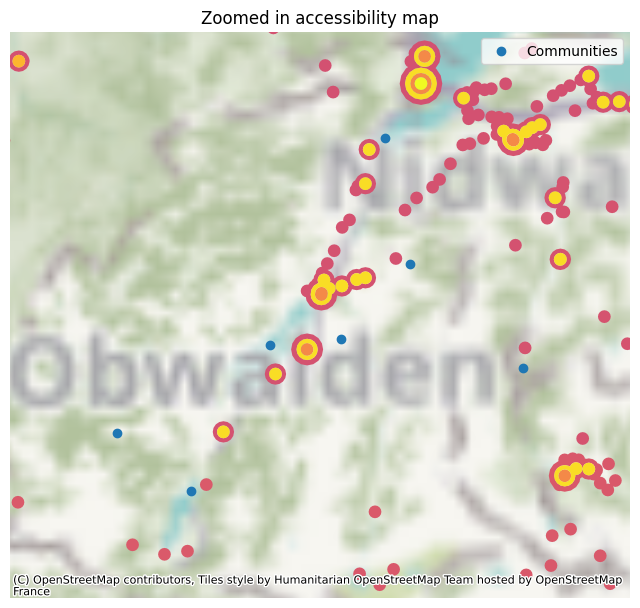

In [403]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.set_title('Zoomed in accessibility map')
ax.set_axis_off()
gdf_access.plot(ax=ax, cmap='plasma')
gdf_reference.plot(ax=ax, label="Communities")
ctx.add_basemap(ax=ax, crs=gdf_reference.crs.to_string())

x_min, x_max = gdf_reference.total_bounds[[0, 2]]
y_min, y_max = gdf_reference.total_bounds[[1, 3]]

expand = 5000  # meters or coordinate units
ax.set_xlim([x_min - expand, x_max + expand])
ax.set_ylim([y_min - expand, y_max + expand])
plt.legend()
plt.show()

The image above is a map visualization indicating the misalignment of coordinate data used in a project, which has resulted in many NaN values during data extraction. The map highlights in blue the coordinates from a previous dataset that do not overlap with the actual areas of interest shown in red and yellow. Due to this discrepancy, a new approach will be adopted using an alternative data source provided through a downloadable CSV file. This file contains data on bus stops and other public transportation facilities. The plan is to aggregate this new data and utilize it in the model to ensure better accuracy and relevance.


In [404]:
#extract the coordinates and names from data points
df_data = pd.read_csv('./data/geodata/OeV_Haltestellen_ARE.csv', encoding='ISO-8859-1', delimiter=';')

#sum the numerical values for the model
numeric = df_data[[ 'Bahnknoten', 'Bahnlinie_Anz', 'TramBus_Anz', 
                    'Seilbahn_Anz', 'A_Intervall', 'B_Intervall', 'Hst_Kat']]

df_data = df_data[['Y_Koord', 'X_Koord', 'Name']]

df_data['access_feature'] = numeric.sum(axis=1)

#filter list to get spots in canton regex is the same as in the portrait
df_data = df_data[df_data["Name"].str.contains(pattern, regex=True)]
df_data.reset_index(inplace=True)
df_data = df_data.drop(["index"], axis=1)

df_data.head(5)
df_data

,Y_Koord,X_Koord,Name,access_feature
0,2673698.29,1185670.26,"Engelberg, Sporting Park",88.60
1,2673634.97,1185972.22,"Engelberg, Kurpark",106.74
2,2673979.17,1185854.17,"Engelberg, Kloster",88.94
3,2674178.74,1185793.04,"Engelberg, Wetti",123.31
4,2674401.10,1185555.88,"Engelberg, Hahnenblick",88.00
...,...,...,...,...
79,2681991.05,1247641.34,"Zürich, Kernstrasse",235.47
80,2673577.95,1185812.31,"Engelberg, Bahnhof",149.63
81,2673050.01,1185477.77,"Engelberg, Titlisbahn",216.20
82,2674540.87,1185731.28,"Engelberg, Brunnibahn",88.00


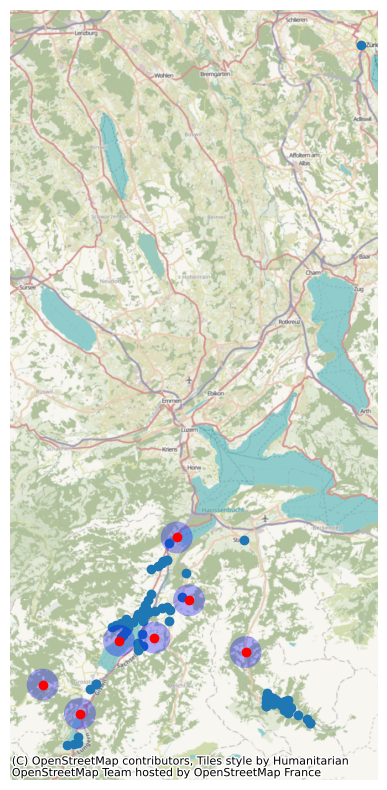

In [405]:
#visualize the filtered data
fig, ax = plt.subplots(1,1, figsize=(7,10))
ax.set_axis_off()
ax.scatter(df_data["Y_Koord"], df_data["X_Koord"], )

# visulaize the regions in which the points should fall
buffer.plot(ax=ax, color='blue', alpha=0.3)
gdf_reference.plot(ax=ax, color='red')
ctx.add_basemap(ax=ax, crs=gdf_reference.crs.to_string())
plt.show()


We have established a solid baseline using the filter method; however, there are still instances where the data points do not correspond to the intended canton or community. Upon examining the dataframe more closely, we identified anomalies such as the presence of "Engelbergstrasse" in Zürich. Despite "Engelberg" being a targeted community and matching the regex, this results in unintended data points. To address this, we will refine our filtering process by employing geopandas to more accurately limit the search to the specific geographic areas of interest.

In [406]:
#additional filtering based on geo points
gdf_data = gpd.GeoDataFrame(
    df_data, crs='epsg:2056', geometry=
    [Point(x, y) for x, y in zip(df_data["Y_Koord"], df_data["X_Koord"])])

gdf_reference = gdf_reference.set_geometry(gdf_reference.buffer(1500))
gdf_data = gpd.sjoin(gdf_data, gdf_reference, how='inner', predicate='within')
gdf_data.drop(["index_right"], axis=1, inplace=True)
gdf_data.head(5)

,Y_Koord,X_Koord,Name,access_feature,geometry,zone_id
30,2663878.98,1200780.02,Alpnachstad,90.00,POINT (2663878.980 1200780.020),Alpnach
37,2665127.90,1195669.03,"Kerns, Sand",100.33,POINT (2665127.900 1195669.030),Kerns
40,2661483.74,1191101.83,"Sachseln, Felsenheim",101.00,POINT (2661483.740 1191101.830),Sachseln
43,2659888.31,1192491.34,"Wilen (Sarnen), Dorf",90.62,POINT (2659888.310 1192491.340),Sarnen
44,2659584.78,1192099.20,"Wilen (Sarnen), Wilerbad",90.62,POINT (2659584.780 1192099.200),Sarnen


In [407]:
#filter the normal datafram
df_data = df_data[df_data["Y_Koord"].isin(gdf_data["Y_Koord"])]
df_data.head(5)

,Y_Koord,X_Koord,Name,access_feature
30,2663878.98,1200780.02,Alpnachstad,90.00
37,2665127.90,1195669.03,"Kerns, Sand",100.33
40,2661483.74,1191101.83,"Sachseln, Felsenheim",101.00
43,2659888.31,1192491.34,"Wilen (Sarnen), Dorf",90.62
44,2659584.78,1192099.20,"Wilen (Sarnen), Wilerbad",90.62


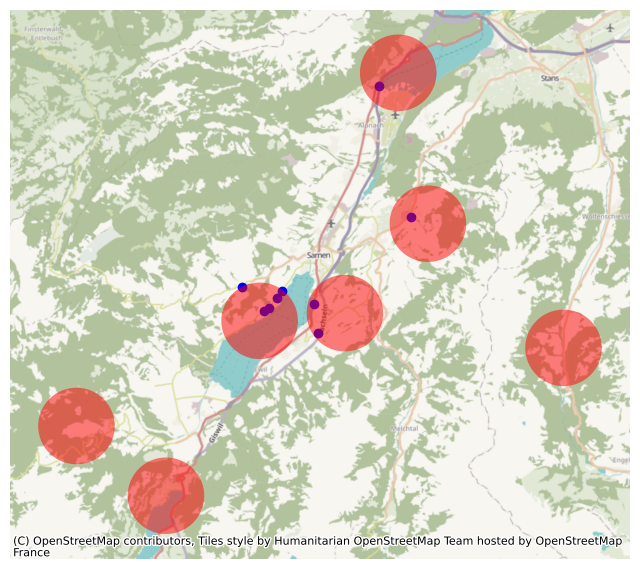

In [408]:
#visualize the filtered data
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_axis_off()
gdf_data.plot(ax=ax, color='blue')

# visulaize the regions in which the points should fall
gdf_reference.plot(ax=ax, color='red', alpha=0.5)
ctx.add_basemap(ax=ax, crs=gdf_reference.crs.to_string())
plt.show()

Now that we got the desired ouput, we are going to group the data into the zones and extract the resulting features from the dataset

In [409]:
#grouping the points to the zone they fall in and suming the features
grouped_data = gdf_data.groupby('zone_id')['access_feature'].sum()
grouped_data = grouped_data.reset_index()
grouped_data.columns = ['Gemeinde', 'access_feature']
grouped_data.set_index("Gemeinde")

df_model_train = df_model.merge(grouped_data, on='Gemeinde', how='left').fillna(0)
df_model_train.set_index("Gemeinde", inplace=True)
df_model_train

C:\Users\viety\AppData\Local\Temp\ipykernel_16884\3676967390.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model_train = df_model.merge(grouped_data, on='Gemeinde', how='left').fillna(0)


,Score,noise_feature,age_feature,Neue Wohnungen,Einwohner,Haushalte,Sozialhilfe,access_feature
Gemeinde,,,,,,,,
Alpnach,36.358415,56,12.551816,2.988048,6053.0,2541.0,1.06,90.00
Engelberg,29.867892,40,23.415451,0.481348,4186.0,1984.0,1.82,0.00
Giswil,15.600230,0,24.548934,1.643385,3657.0,1519.0,0.85,0.00
Kerns,28.282596,18,44.169165,7.783956,6295.0,2554.0,0.85,100.33
Lungern,13.429064,24,6.415094,3.770028,2111.0,926.0,1.27,0.00
Sachseln,38.345778,29,0.000000,7.855460,5170.0,2135.0,0.80,202.00
Sarnen,100.000000,28,0.000000,8.010942,10458.0,4533.0,1.13,456.26


# Finding the best boosted and linear model

In [410]:
#testing the model with the collected features so far
df_train = df_model_train.drop("Score", axis=1)
y = df_model_train["Score"]
score, boosting = runScoringSimple(df_model, 'Score')
print(f'linear:     {score}')
print(f'boosting:   {boosting}')

linear:     -318.8280286407889
boosting:   -864.9063800065255


Now that we have enough data, it is time to extend our features through feature engineering. The data above gives us a good starting line. The goal of this project is, to get both the linear and boosting model as close as possible to 0. The first model we are focusing on is the linear model. Lets have a look at our data and see if we can see some linear trends with the target variable score

In [411]:
def train_single_feature(df, y):
    #testing how well the standalone features do on the model
    # return a list of scors
    scores_linear = []
    scores_boost = []
    for feature, data in df.items():
        X = data.to_numpy().reshape((-1,1))

        linear = scoreLinear(X, y)
        boost = scoreBoosting(X, y)

        scores_linear.append(linear)
        scores_boost.append(boost)

    return scores_linear, scores_boost

In [412]:
def scores_bigger_x(scores, x):
    indicies = [i for i, num in enumerate(scores) if num >= x]
    return indicies


def scores_under_x(scores, x):
    indicies = [i for i, num in enumerate(scores) if num <= x]
    return indicies

def min_max_normalize(X):
    min_val = np.min(X)
    max_val = np.max(X)

    denominator = max_val - min_val

    return (X-min_val) / denominator

def find_best_score_features(df, y):
    overall_linear_scores = []
    overall_boosting_scores = []

    features_linear = []
    features_boost = []

    scores_linear, scores_boost = train_single_feature(df, y)

    # find the threshhold / combination of features which give you the overall best score
    for linear, boost in zip(scores_linear, scores_boost):

        #filtering the indices
        indices_linear = scores_under_x(scores_linear, linear) if score > 0 else scores_bigger_x(scores_linear, linear)
        indices_boost = scores_under_x(scores_boost, boost) if score > 0 else scores_bigger_x(scores_boost, boost)
        
        #extract the data with the indices
        X_linear = df[df.columns[indices_linear]]
        X_boost = df[df.columns[indices_boost]]
        features_linear.append(X_linear)
        features_boost.append(X_boost)

        #calculate the score
        linear = scoreLinear(X_linear, y)
        boost = scoreBoosting(X_boost, y)

        overall_linear_scores.append(linear)
        overall_boosting_scores.append(boosting)
    
    overall_min_linear = overall_linear_scores.index(max(overall_linear_scores))
    overall_min_boosting = overall_boosting_scores.index(max(overall_boosting_scores))

    #return the values which give the best result
    return features_linear[overall_min_linear], features_boost[overall_min_boosting]

In [413]:
def score_features(df, y):
    X_linear, X_boost = find_best_score_features(df, y)
    linear = scoreLinear(X_linear, y)
    boost = scoreBoosting(X_boost, y)
    print(f'Score linear is:    {linear}')
    print(f'Score boost is:     {boost}')
    
    return X_linear, X_boost, linear, boost

In [414]:
def find_best_engineered(df, y, identifier, func, start=1):

    X_engineered_l = {}
    X_engineered_b = {}

    old_score_l = -np.inf
    old_score_b = -np.inf

    for i in range(start, 5):
        df_power = df.apply(lambda x: func(x, i))
        print(f"Loop features through function with val: {i}")
        X_l, X_b, score_l, score_b = score_features(df_power, y)

        if(old_score_l < score_l):
            old_score_l = score_l
            X_engineered_l = X_l

        if(old_score_b < score_b):
            old_score_b = score_b
            X_engineered_b = X_b

        print("---------------------------------------")
    
    X_engineered_l.columns = [name +  identifier for name, data in X_engineered_l.items()]
    X_engineered_b.columns = [name + identifier for name, data in X_engineered_b.items()]
    return X_engineered_l, X_engineered_b

## Finding the best Features without normaliziation

In [415]:
#base case best feature
X_linear, X_boost, score_l, score_b = score_features(df_train, y)

Score linear is:    -23.898651011442507
Score boost is:     -882.6598786583172


In [416]:
#best features for linear model without feature engineering
print(f'The best linear features without feature engineering:')
print(X_linear.columns.to_numpy())
print()
print("The best boosting features without feature engineering: ")
print(X_boost.columns.to_numpy())

The best linear features without feature engineering:
['Einwohner' 'Haushalte' 'access_feature']

The best boosting features without feature engineering: 
['noise_feature' 'age_feature' 'Neue Wohnungen' 'Einwohner' 'Haushalte'
 'Sozialhilfe' 'access_feature']


## Power approach

In [417]:
X_power_l, X_power_b = find_best_engineered(df_train, y, "pow", lambda x, i : x**i)



Loop features through function with val: 1
Score linear is:    -23.898651011442507
Score boost is:     -882.6598786583172
---------------------------------------
Loop features through function with val: 2
Score linear is:    -60.61833202437478
Score boost is:     -881.6070070396063
---------------------------------------
Loop features through function with val: 3
Score linear is:    -68.22614384083379
Score boost is:     -888.9291595241493
---------------------------------------
Loop features through function with val: 4
Score linear is:    -342.6784459974986
Score boost is:     -877.8440992514221
---------------------------------------


## Taking the nth root

In [418]:
X_root_l, X_root_b = find_best_engineered(df_train, y, "root", lambda x, i: x**(1/i))


Loop features through function with val: 1
Score linear is:    -23.898651011442507
Score boost is:     -882.6598786583172
---------------------------------------
Loop features through function with val: 2
Score linear is:    -465.84683846179996
Score boost is:     -890.7477073657882
---------------------------------------
Loop features through function with val: 3
Score linear is:    -494.3513305539389
Score boost is:     -890.7477073657882
---------------------------------------
Loop features through function with val: 4
Score linear is:    -558.7328379326435
Score boost is:     -890.9354923861794
---------------------------------------


## Log approach

In [419]:
# we have also 0 values in the set replace them with 0 to get a log value of 0
X_log_l, X_log_b = find_best_engineered(
                                            df_train.replace(0, 1), y, "log", 
                                            lambda x, i: np.log(x) / np.log(i), start=2
                                        )


Loop features through function with val: 2
Score linear is:    -898.4355488951256
Score boost is:     -891.2130269680032
---------------------------------------
Loop features through function with val: 3
Score linear is:    -709.9991099291319
Score boost is:     -891.2130269680032
---------------------------------------
Loop features through function with val: 4
Score linear is:    -898.4355488951256
Score boost is:     -891.2130269680032
---------------------------------------


## Model with the lowest score not normalized

Because we have to skip the first iteration and the log approach shows a consistent increase of the score, the features which were chosen from the function are omitted to get a better score

In [420]:

feature_l = [X_power_l, X_root_l, X_log_b]
feature_b = [X_power_b, X_root_b, X_log_b]
feature_names = ["power", "root", "log"]
df_linear_model = X_linear
df_boost_model = X_boost

print("Starting with the linear model: \n")
for name, data in zip(feature_names, feature_l):

    df_feature_model = X_linear.join(data)
    score_feature = scoreLinear(df_feature_model, y)

    df_linear_model = df_linear_model.join(data)
    score = scoreLinear(df_linear_model, y)
    
    print(f"Testing combination variable: {name}")
    print(f"The score variable and base:  {score_feature}")
    print(f"Testing combination:          {score}")
    print("------------------------------------------------------")

print('\nStarting with the boosting model: \n')
for name, data in zip(feature_names, feature_b):

    df_feature_model = X_boost.join(data)
    score_feature = scoreBoosting(df_feature_model, y)

    df_boost_model = df_boost_model.join(data)
    score = scoreBoosting(df_boost_model, y)

    print(f"Testing combination variable:   {name}")
    print(f"The score variable and base:    {score_feature}")
    print(f"Testing combination:            {score}")
    print("------------------------------------------------------")

Starting with the linear model: 

Testing combination variable: power
The score variable and base:  -23.89865101144272
Testing combination:          -23.89865101144272
------------------------------------------------------
Testing combination variable: root
The score variable and base:  -23.89865101144272
Testing combination:          -23.898651011441725
------------------------------------------------------
Testing combination variable: log
The score variable and base:  -98.70262848223867
Testing combination:          -98.13208554205092
------------------------------------------------------

Starting with the boosting model: 

Testing combination variable:   power
The score variable and base:    -823.8892077656192
Testing combination:            -823.8892077656192
------------------------------------------------------
Testing combination variable:   root
The score variable and base:    -829.3752659174262
Testing combination:            -831.8342176179998
------------------------------

# Finding best model with normalized data

In [421]:
#normalized approach base
df_train_normalized = df_train.apply(min_max_normalize)
y_normalized = min_max_normalize(y)
X_linear_n, X_boost_n = find_best_score_features(df_train_normalized, y_normalized)

linear = scoreLinear(X_linear, y_normalized)
boost = scoreBoosting(X_boost, y_normalized)
print(f'Score linear is:    {linear}')
print(f'Score boost is:     {boost}')

Score linear is:    -0.0031888137843523816
Score boost is:     -0.11812692944015785


In [422]:
#best features for linear model without feature engineering
print(f'The best linear normalized:')
print(X_linear_n.columns.to_numpy())
print()
print("The best boosting normalized: ")
print(X_boost_n.columns.to_numpy())

The best linear normalized:
['Einwohner' 'Haushalte' 'access_feature']

The best boosting normalized: 
['noise_feature' 'age_feature' 'Neue Wohnungen' 'Einwohner' 'Haushalte'
 'Sozialhilfe' 'access_feature']


## Power approach

In [423]:
#testing the model with different powers
X_pow_norm_l, X_pow_norm_b = find_best_engineered(
                                                    df_train_normalized, y_normalized, "pow",
                                                    lambda x, i: x**i
                                                )

Loop features through function with val: 1
Score linear is:    -0.00318881378435238
Score boost is:     -0.12080259572557427
---------------------------------------
Loop features through function with val: 2
Score linear is:    -0.008346755865639986
Score boost is:     -0.11897630355403988
---------------------------------------
Loop features through function with val: 3
Score linear is:    -0.040906494031058914
Score boost is:     -0.11897648641824592
---------------------------------------
Loop features through function with val: 4
Score linear is:    -0.175045262680353
Score boost is:     -0.11726262972652578
---------------------------------------


## Taking the nth root

In [424]:
X_root_norm_l, X_root_norm_b = find_best_engineered(
                                                        df_train_normalized, y_normalized, "root",
                                                        lambda x, i: x**(1/i)
                                                    )

Loop features through function with val: 1
Score linear is:    -0.00318881378435238
Score boost is:     -0.12080259572557427
---------------------------------------
Loop features through function with val: 2
Score linear is:    -0.08528549672044916
Score boost is:     -0.1202472769765421
---------------------------------------
Loop features through function with val: 3
Score linear is:    -0.07391081030292561
Score boost is:     -0.12025321275326835
---------------------------------------
Loop features through function with val: 4
Score linear is:    -0.06999572827550891
Score boost is:     -0.12025321275326835
---------------------------------------


## Log approach

In [425]:
# we have also 0 values in the set replace them with 0 to get a log value of 0
X_log_norm_l, X_log_norm_b = find_best_engineered(
                                                        df_train_normalized.replace(0, 1), y_normalized, "log",
                                                        lambda x, i: np.log(x) / np.log(i), start=2
                                                 )


Loop features through function with val: 2
Score linear is:    -0.13003954127204417
Score boost is:     -0.393801421200824
---------------------------------------
Loop features through function with val: 3
Score linear is:    -0.13003954127204412
Score boost is:     -0.393801421200824
---------------------------------------
Loop features through function with val: 4
Score linear is:    -0.13003954127204417
Score boost is:     -0.393801421200824
---------------------------------------


## Model with lowest score with normalized data

In [427]:

feature_norm_l = [X_pow_norm_l, X_root_norm_l, X_log_norm_b]
feature_norm_b = [X_pow_norm_b, X_root_norm_b, X_log_norm_b]
feature_names = ["power", "root", "log"]
df_linear_norm = X_linear_n
df_boost_norm = X_boost_n

print("Starting with the linear model:\n")
for name, data in zip(feature_names, feature_l):
    df_feature_model = X_linear_n.join(data)
    score_feature = scoreLinear(df_feature_model, y_normalized)
    df_linear_norm = df_linear_norm.join(data)
    score = scoreLinear(df_linear_model, y_normalized)
    print(f"Testing combination variable: {name}")
    print(f"The score variable and base:  {score_feature}")
    print(f"Testing combination:          {score}")
    print("------------------------------------------------------")

print("\nStarting with the boosting model:\n")
for name, data in zip(feature_names, feature_b):
    df_feature_model = X_boost_n.join(data)
    score_feature = scoreLinear(df_feature_model, y_normalized)
    df_boost_norm = df_boost_norm.join(data)
    score = scoreBoosting(df_boost_norm, y_normalized)
    print(f"Testing combination variable:   {name}")
    print(f"The score variable and base:    {score_feature}")
    print(f"Testing combination:            {score}")
    print("------------------------------------------------------")

Starting with the linear model:

Testing combination variable: power
The score variable and base:  -0.0031888137843524653
Testing combination:          -0.013093833075093297
------------------------------------------------------
Testing combination variable: root
The score variable and base:  -0.0031888137843524653
Testing combination:          -0.013093833075093297
------------------------------------------------------
Testing combination variable: log
The score variable and base:  -0.13125129282613032
Testing combination:          -0.013093833075093297
------------------------------------------------------

Starting with the boosting model:

Testing combination variable:   power
The score variable and base:    -2.5945664821615293
Testing combination:            -0.11151177445739467
------------------------------------------------------
Testing combination variable:   root
The score variable and base:    -0.02790635439730622
Testing combination:            -0.1115731815486644
--------